In [30]:
import json
from urllib.request import urlopen

import matplotlib.pyplot as plt
import pandas as pd
from requests import Request, Session
import numpy as np

In [2]:
def get_prices(tickers='all'):
    session = Session()

    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/map'
    headers = {
        'Accepts': 'application/json', 
        'X-CMC_PRO_API_KEY': '1a073c3f-c968-40d8-9dcf-0340a3bd5796'
    }

    r = session.get(url, headers=headers)
    r = r.json()

    ids = { d['symbol']: d['id'] for d in r['data'] }

    df = pd.DataFrame()

    if tickers != 'all':
        ids = [(symbol, id) for symbol, id in ids.items() if symbol in tokens]
    else:
        ids = [(symbol, id) for symbol, id in ids.items()]
    
    for symbol, id in ids:

        url = f"https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical?id={id}&convertId=2781&timeStart=1514808000&timeEnd=1647172800"
        r = session.get(url, headers=headers)
        r = r.json()
        
        df_tmp = pd.DataFrame([{d['quote']['timestamp']: d['quote']['close'] for d in r['data']['quotes']}]).T.rename(columns={0: symbol})
        df = pd.merge(df, df_tmp, right_index=True, left_index=True, how='right')

    return df

In [3]:
tokens = ['BTC', 'ETH', 'DOGE', 'ADA', 'DOT']

prices = get_prices(tokens)
returns = prices.pct_change().dropna()

In [49]:
def ma_strat(long_term_window, short_term_window, returns):
    ma_long_term = prices.rolling(long_term_window).mean()
    ma_short_term = prices.rolling(short_term_window).mean()

    mask = ma_long_term.iloc[:,0].isna()
    ma_long_term = ma_long_term.loc[~mask]
    ma_short_term = ma_short_term.loc[~mask]
    returns = returns.loc[~mask]

    strat = 2*(ma_short_term > ma_long_term) - 1
    strat_returns = strat*(returns.shift(-1))
    
    return strat_returns, strat

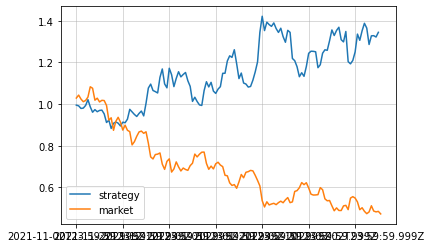

In [51]:
strat_returns, strat = ma_strat(50, 15, returns)

fig, ax = plt.subplots()
(1+strat_returns).cumprod().mean(axis=1).plot(ax=ax, label="strategy")
(1+returns).loc[strat_returns.index, :].cumprod().mean(axis=1).plot(ax=ax, label="market")
plt.grid(alpha=0.6)
plt.legend(loc="lower left")
plt.show()

In [52]:
def volatility(strat_returns):
    cum_returns = strat_returns.dropna().mean(axis=1)
    annualized_vol = cum_returns.std()*np.sqrt(252)
    return annualized_vol

# RF RATE MISSING
def sharpe_ratio(strat_returns):
    cum_returns = strat_returns.dropna().mean(axis=1)
    sr = cum_returns.mean()/cum_returns.std()
    annualized_sr = sr*np.sqrt(252)
    return annualized_sr

def max_drawdown(strat_returns):
    cum_returns = strat_returns.dropna().mean(axis=1)
    max_dd = (cum_returns.iloc[-1] - cum_returns.max())/cum_returns.max()
    return max_dd


In [53]:
sharpe_ratio(strat_returns)

1.3103786863981473

In [55]:
max_drawdown(strat_returns)

-0.8722526145098449